In [1]:
!pip install torch torchvision numpy matplotlib opencv

ERROR: Could not find a version that satisfies the requirement opencv (from versions: none)
ERROR: No matching distribution found for opencv


In [2]:
!pip install configparser


In [1]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from tqdm import tqdm

In [80]:
data_dir = os.path.join("/content/drive/MyDrive/Task09_Spleen")
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

image shape: torch.Size([228, 158, 113]), label shape: torch.Size([228, 158, 113])


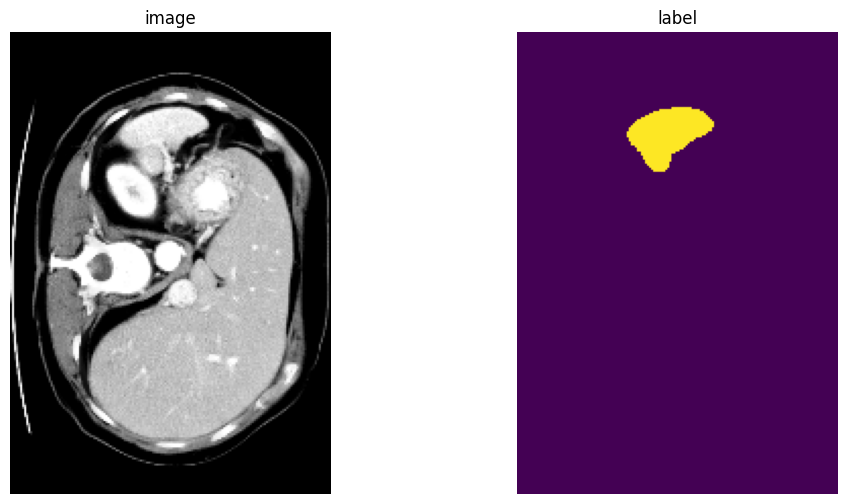

In [75]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)


check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.axis("off")
plt.show()




torch.Size([512, 512, 50])


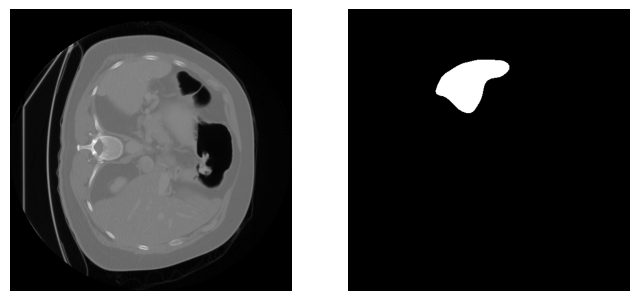

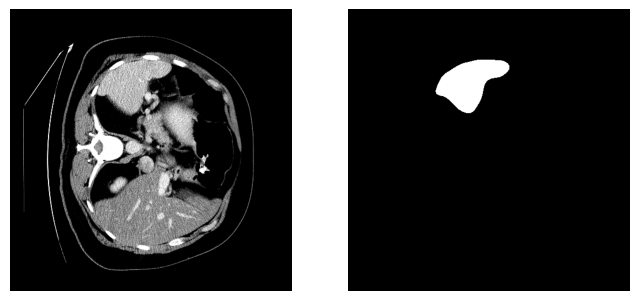

torch.Size([1, 512, 512, 50])


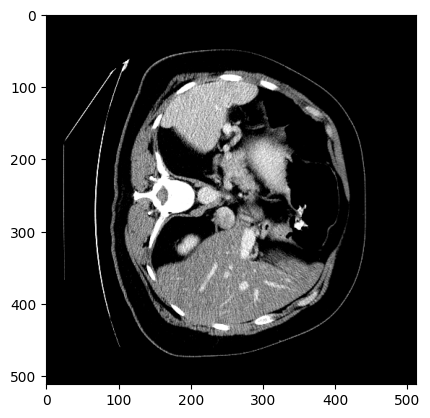

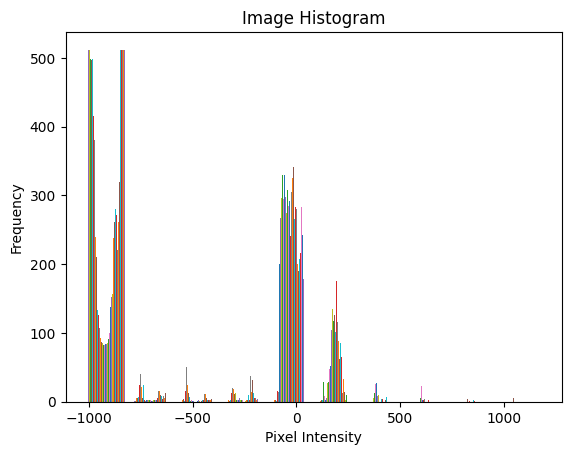

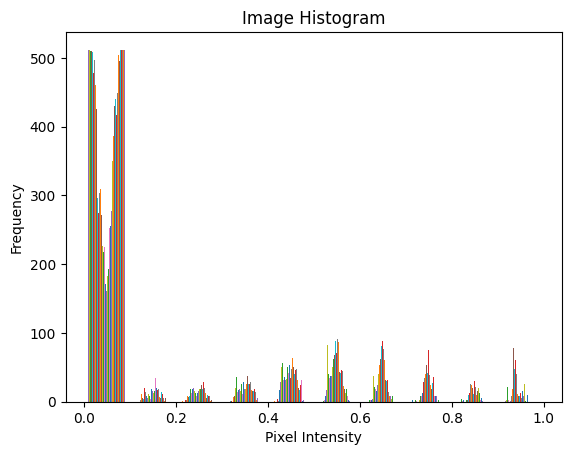

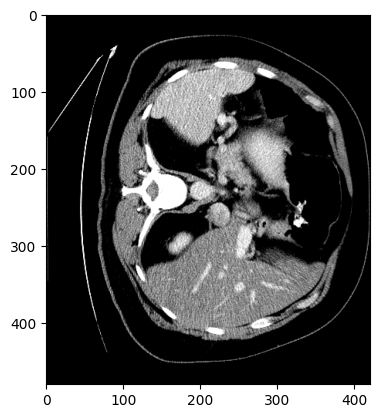

In [76]:
import numpy as np

# Loading image and label
result1 = LoadImaged(keys=["image", "label"])(val_files[1])
print(result1["image"].shape)
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
plt.imshow(result1["image"][:,:,30], cmap="gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(result1["label"][:,:,30], cmap="gray")
plt.axis("off")
plt.show()

# Scaling Pixel Intensity
result2 = EnsureChannelFirstd(keys=["image", "label"])(result1)
# print(np.max(result2["image"][0,:,:,30]))
result = ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        )(result2)
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
plt.imshow(result["image"][0,:,:,30], cmap="gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(result["label"][0,:,:,30], cmap="gray")
plt.axis("off")
plt.show()

# print(np.min(result["image"][0]))
print(result["label"].shape)
plt.imshow(result["image"][0,:,:,30], cmap="gray")

plt.show()
plt.hist(result1["image"][:,:,30])
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Image Histogram")
plt.show()
plt.hist(result["image"][0,:,:,30])
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Image Histogram")
plt.show()

cropped = CropForegroundd(keys=["image", "label"], source_key="image")(result)
plt.imshow(cropped["image"][0,:,:,30], cmap="gray")


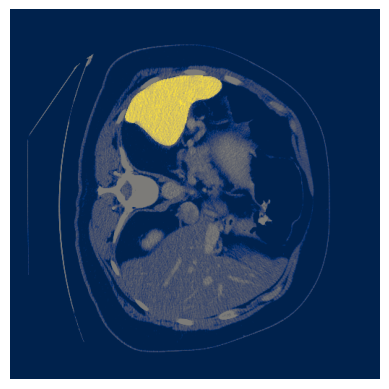

In [77]:
# Overlaying mask over image
plt.imshow(result["image"][0,:,:,30]+result["label"][0,:,:,30], cmap="cividis")
plt.axis("off")
plt.show()

In [78]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=2)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)


Loading dataset: 100%|██████████| 9/9 [00:25<00:00,  2.81s/it]


In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")


In [85]:

max_epochs = 246
val_interval = 2
checkpoint = torch.load("/content/drive/MyDrive/Task09_Spleen/ImprovedResults/my_checkpoint.pth.tar", map_location=torch.device('cpu'))
best_metric = checkpoint["best_metric"]
best_metric_epoch = checkpoint["best_metric_epoch"]
epoch_loss_values = checkpoint["train_loss"]
metric_values = checkpoint["val_dice"]
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])
save_dir = "/content/drive/MyDrive/Task09_Spleen/ImprovedResults"
checkpoint = {}

for epoch in range(240, max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in tqdm(train_loader):
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print(
        #     f"{step}/{len(train_ds) // train_loader.batch_size}, "
        #     f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    save_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
    checkpoint["train_loss"] = epoch_loss_values
    checkpoint["val_dice"] = metric_values
    checkpoint["best_metric_epoch"] = best_metric_epoch
    checkpoint["best_metric"] = best_metric
    checkpoint["model_state_dict"] = model.state_dict()
    checkpoint["optimizer_state_dict"] = optimizer.state_dict()
    torch.save(checkpoint, os.path.join(save_dir, "my_checkpoint2.pth.tar"))


<ipython-input-85-c4363729703b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/drive/MyDrive/Task09_Spleen/ImprovedResults/my_checkpoint.

----------
epoch 241/246


100%|██████████| 16/16 [02:17<00:00,  8.57s/it]


epoch 241 average loss: 0.1560
----------
epoch 242/246


100%|██████████| 16/16 [02:21<00:00,  8.84s/it]

epoch 242 average loss: 0.2025


current epoch: 242 current mean dice: 0.4214
best mean dice: 0.9448 at epoch: 236
----------
epoch 243/246


100%|██████████| 16/16 [02:22<00:00,  8.93s/it]


epoch 243 average loss: 0.2032
----------
epoch 244/246


100%|██████████| 16/16 [02:18<00:00,  8.65s/it]

epoch 244 average loss: 0.1833


current epoch: 244 current mean dice: 0.9216
best mean dice: 0.9448 at epoch: 236
----------
epoch 245/246


100%|██████████| 16/16 [02:15<00:00,  8.48s/it]


epoch 245 average loss: 0.1993
----------
epoch 246/246


100%|██████████| 16/16 [02:16<00:00,  8.52s/it]

epoch 246 average loss: 0.1810


current epoch: 246 current mean dice: 0.6085
best mean dice: 0.9448 at epoch: 236


In [86]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.9448 at epoch: 236


In [87]:
# Loading the checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load("/content/drive/MyDrive/Task09_Spleen/ImprovedResults/my_checkpoint2.pth.tar", map_location=device)
checkpoint.keys()

<ipython-input-87-0aae96dd6c59>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/drive/MyDrive/Task09_Spleen/ImprovedResults/my_checkpoint2

dict_keys(['train_loss', 'val_dice', 'best_metric_epoch', 'best_metric', 'model_state_dict', 'optimizer_state_dict'])

[0.1142536923289299, 0.1540801227092743, 0.0855107381939888, 0.09856516122817993, 0.18660323321819305, 0.18950875103473663, 0.23578855395317078, 0.21683935821056366, 0.17297786474227905, 0.28501227498054504]


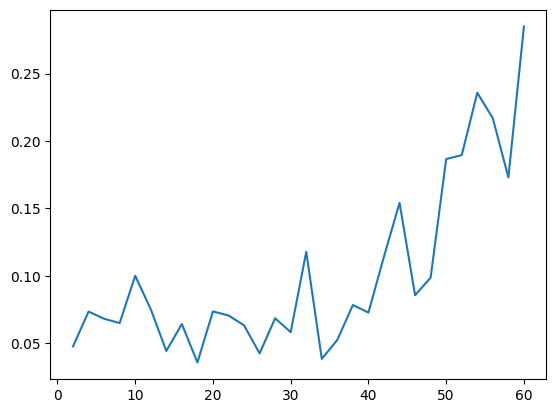

In [88]:
val_dice = checkpoint["val_dice"]
x = [2 * (i + 1) for i in range(len(checkpoint["val_dice"][0:30]))]
y = checkpoint["val_dice"][0:30]
plt.plot(x,y)
print(val_dice[20:30])

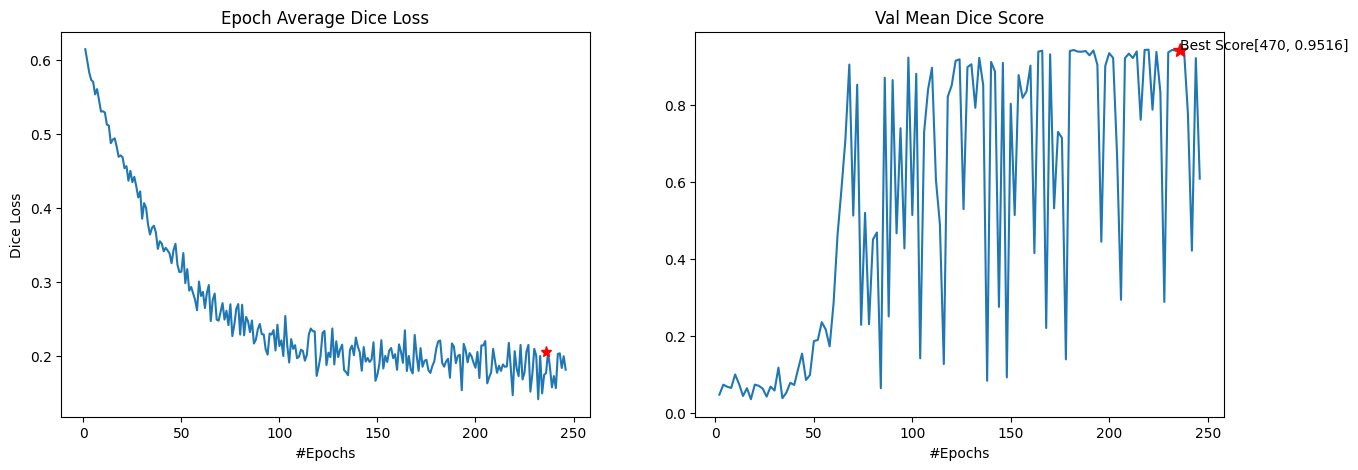

In [89]:
val_interval = 2
plt.figure("train", (15, 5))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Dice Loss")
x = [i + 1 for i in range(len(checkpoint["train_loss"]))]
y = checkpoint["train_loss"]
plt.xlabel("#Epochs")
plt.ylabel("Dice Loss")
plt.plot(x, y)
plt.plot(checkpoint["best_metric_epoch"], checkpoint["train_loss"][checkpoint["best_metric_epoch"]], 'r*', markersize=8)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice Score")
x = [val_interval * (i + 1) for i in range(len(checkpoint["val_dice"]))]
y = checkpoint["val_dice"]
plt.xlabel("#Epochs")
plt.plot(x, y)
plt.plot(checkpoint["best_metric_epoch"], checkpoint["val_dice"][checkpoint["best_metric_epoch"]//2], 'r*', markersize=10)
plt.annotate("Best Score[470, 0.9516]", xy=(checkpoint["best_metric_epoch"], checkpoint["val_dice"][checkpoint["best_metric_epoch"]//2]))
plt.savefig("LearningCurves.png")
plt.show()


In [90]:
checkpoint["best_metric_epoch"]

236

In [91]:
import time
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=2)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

Loading dataset: 100%|██████████| 9/9 [00:19<00:00,  2.19s/it]


<ipython-input-92-c5f6af6356ed>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(


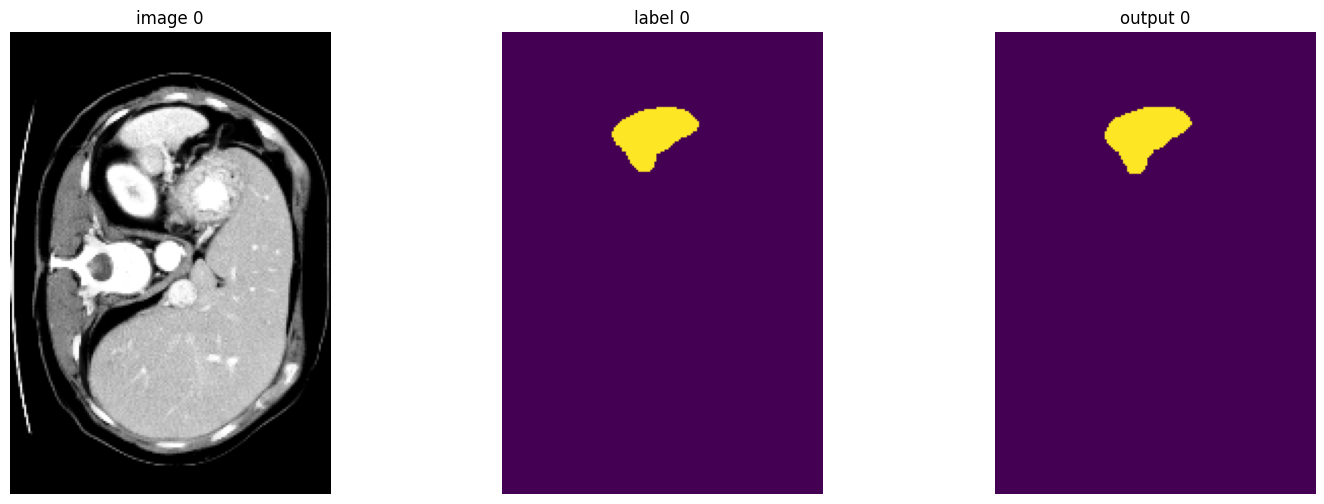

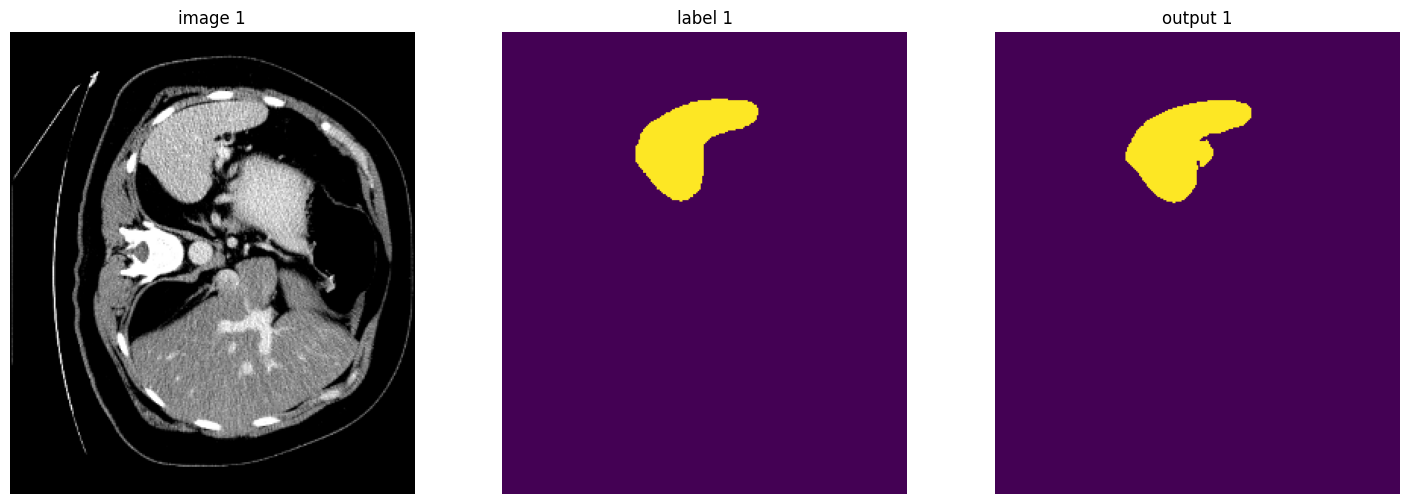

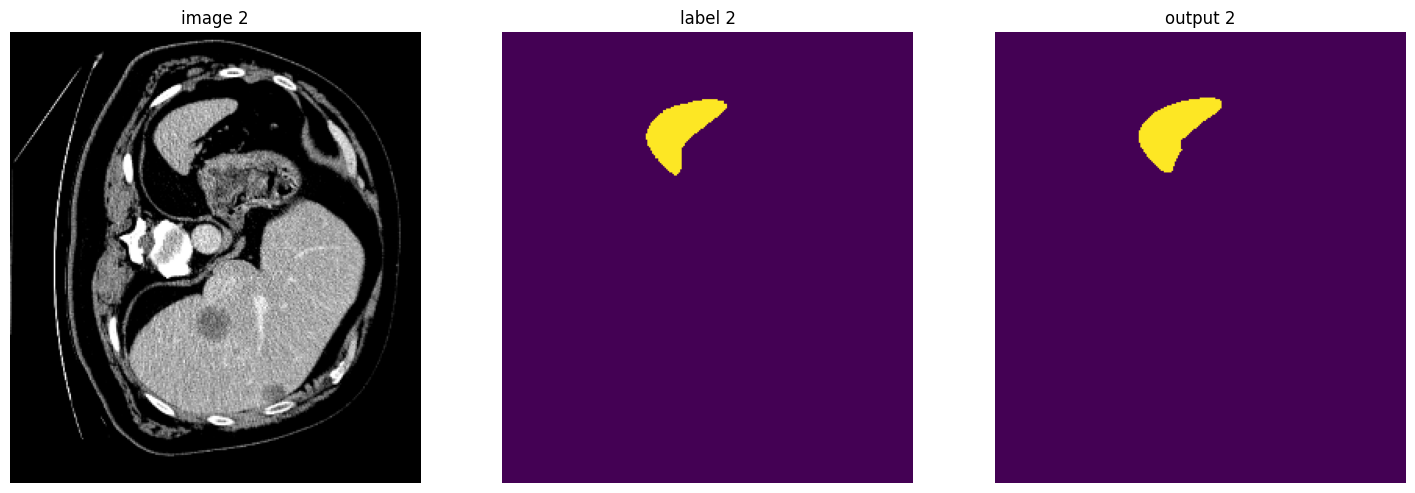

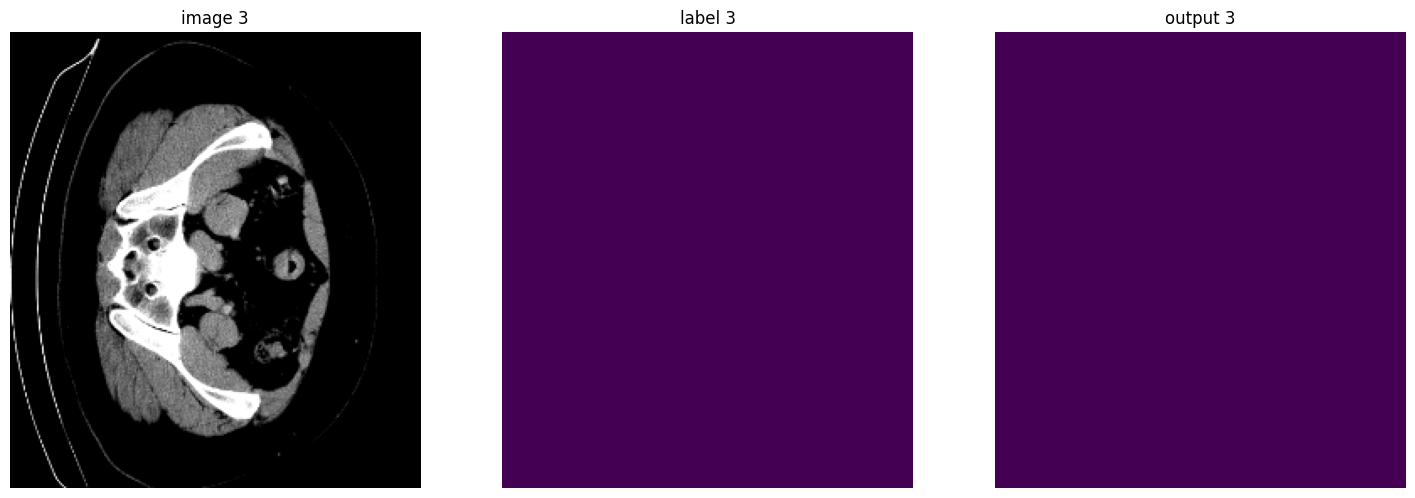

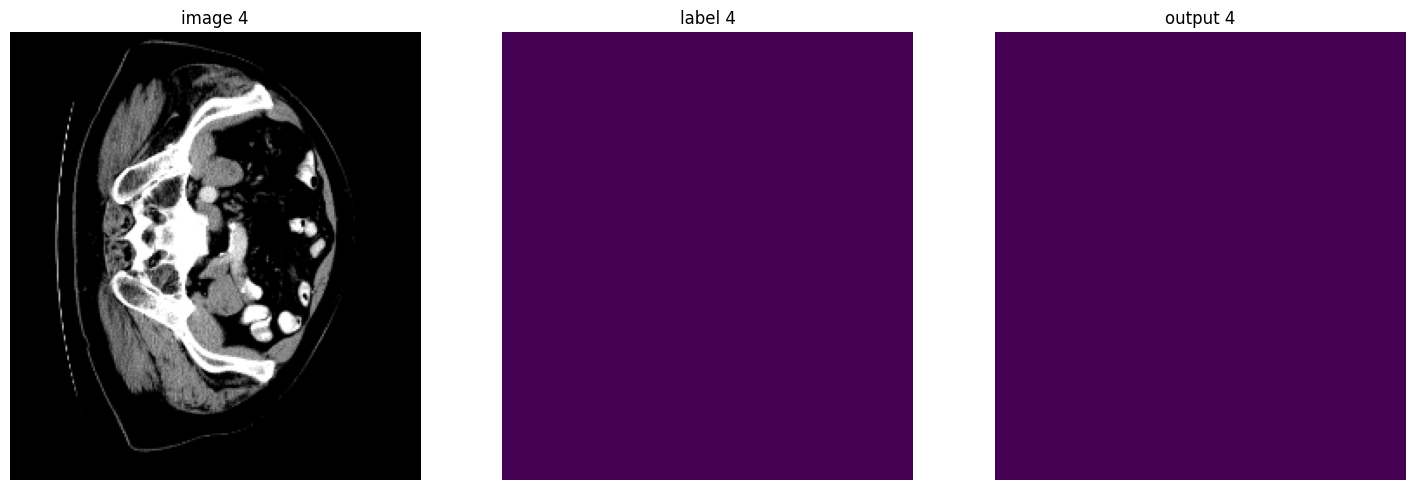

In [92]:
save_dir = "/content/drive/MyDrive/Task09_Spleen/ImprovedResults"
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

model.load_state_dict(torch.load(
    os.path.join(save_dir, "best_metric_model.pth"), map_location=device))
model.eval()
# elapsed_time = 0
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        # t = time.time()
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # elapsed_time += time.time() - t
        # print("Elapse Time : ", time.time()-t)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.axis("off")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.axis("off")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 4:
            break

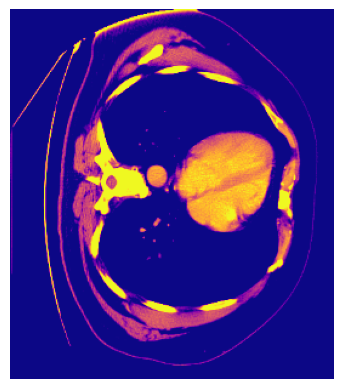

In [93]:

import matplotlib.pyplot as plt
# import matplotlib.cm as cm
import matplotlib.animation as animation

img = [] # some array of images
frames = [] # for storing the generated images

roi_size = (160, 160, 160)
sw_batch_size = 4
for i, data in enumerate(val_loader):
  val_data = data
  if i == 1:
    break
# val_data = first(val_loader)
val_outputs = sliding_window_inference(
    val_data["image"].to(device), roi_size, sw_batch_size, model
)
outputs = torch.argmax(val_outputs, dim=1)
fig = plt.figure()
plt.axis("off")
for i in range(val_data["image"].shape[-1]):
    frames.append([plt.imshow(val_data["image"][0,0,:,:,i]+(1.5*val_data["label"][0,0,:,:,i])+(1.5*outputs[0,:,:,i]), cmap="plasma",animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True,
                                repeat_delay=2000)
ani.save('movie.mp4')
plt.show()